## Backtesting

### imports

In [34]:
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import ffn
import logging
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import Optional
from abc import ABC, abstractmethod


# Configure logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# Load configuration from YAML
def load_config(yaml_file_path):
    with open(yaml_file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config



#### Signal

In [35]:

class BaseSignal(ABC):
    def __init__(self, current_price, buy_signal, sell_signal, exit_signal):
        self.current_price = current_price
        self.buy_signal = eval(buy_signal["function"])
        self.sell_signal = eval(sell_signal["function"])
        self.exit_signal = eval(exit_signal["function"])
        self.buy_threshold = buy_signal["params"]["buy_threshold"]
        self.sell_threshold = sell_signal["params"]["sell_threshold"]
        self.exit_threshold = exit_signal["params"]["exit_threshold"]

    @abstractmethod
    def generate_buy_signal(self, predicted_high):
        pass

    @abstractmethod
    def generate_sell_signal(self, buy_price):
        pass

    @abstractmethod
    def generate_exit_signal(self, buy_price, predicted_high):
        pass

class Signal(BaseSignal):
    def generate_buy_signal(self, predicted_high):
        return self.buy_signal(self.current_price, predicted_high, self.buy_threshold)

    def generate_sell_signal(self, buy_price):
        return self.sell_signal(self.current_price, buy_price, self.sell_threshold) if buy_price else False

    def generate_exit_signal(self, buy_price, predicted_high):
        return self.exit_signal(self.current_price, buy_price, predicted_high, self.exit_threshold) if buy_price else False

#### Strategy

In [36]:

class BaseStrategy(ABC):
    def __init__(self, config):
        strategy_config = config["strategies"]["trading_strategy"]["params"]
        self.initial_cash = strategy_config["initial_cash"]
        self.position_size_factor = strategy_config["position_size_factor"]
        self.cash = self.initial_cash
        self.position = 0
        self.buy_price = None
        self.total_trades = 0
        self.winning_trades = 0
        self.losing_trades = 0
        self.portfolio_value = []
        self.current_price = None
        self.decisions = []
        self.previous_signal = None
        self.signal_strength = 1
        self.signal = None

    def make_decision(self, timestamp, prediction, action, current_price):
        """Log each decision with debugging information."""
        self.decisions.append({
            "timestamp": timestamp,
            "prediction": prediction,
            "action": action,
            "current_price": current_price,
            "actual_price": None,
        })

    @abstractmethod
    def buy(self, future_timestamp, predicted_high):
        """Execute a buy decision."""
        pass

    @abstractmethod
    def sell(self, future_timestamp, predicted_high):
        """Execute a sell decision."""
        pass

    @abstractmethod
    def exit(self, future_timestamp, predicted_high):
        """Execute an exit decision."""
        pass

    @abstractmethod
    def execute_trade(self, signal, future_timestamp, predicted_high, current_price):
        """Execute trades based on signals and manage positions."""
        pass

    def print_trade_statistics(self):
        """Print the total trades and winning trades."""
        print(f"Total Trades: {self.total_trades}, Winning Trades: {self.winning_trades}, Losing Trades: {self.losing_trades}")

    def fetch_actual_price(self, timestamp):
        try:
            mask = self.X_test_df.index == timestamp
            actual_row = self.X_test_df.loc[mask].iloc[0] if not self.X_test_df.loc[mask].empty else None

            if actual_row is not None:
                return actual_row['high']
            else:
                return None
        except KeyError:
            return None

    def evaluate_decisions(self):
        y_true = []
        y_pred = []
        for decision in self.decisions:
            actual_price = self.fetch_actual_price(decision["timestamp"])
            decision["actual_price"] = actual_price
            #print(f"Evaluated Decision at {decision['timestamp']}: predicted {decision['prediction']}, "
             #     f"actual {decision['actual_price']}, action: {decision['action']}")
                        # Determine the actual action based on the actual price
            if actual_price is not None:
                if decision["action"] == "buy":
                    y_pred.append(1)  # Predicted buy
                    y_true.append(1 if actual_price > decision["current_price"] else 0)  # Actual buy if price increased
                elif decision["action"] == "sell":
                    y_pred.append(0)  # Predicted sell
                    y_true.append(0 if actual_price < decision["current_price"] else 1)  # Actual sell if price decreased
             

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Buy", "Sell"])
        disp.plot()
        plt.title("Confusion Matrix of Trading Decisions")
        plt.show()

        # Print confusion matrix
        print("Confusion Matrix:")
        print(cm)

        # Calculate relative values
        cm_relative = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Print relative confusion matrix
        print("Relative Confusion Matrix:")
        print(cm_relative)

        # Display relative confusion matrix
        disp_relative = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=["Buy", "Sell"])
        disp_relative.plot()
        plt.title("Relative Confusion Matrix of Trading Decisions")
        plt.show()

class Strategy(BaseStrategy):
    def buy(self, future_timestamp, predicted_high):
        """Execute a buy decision."""
        amount_to_invest = self.position_size_factor * self.cash * self.signal_strength
        shares_to_buy = amount_to_invest // self.current_price
        self.cash -= shares_to_buy * self.current_price
        self.position += shares_to_buy
        self.buy_price = self.current_price
        self.total_trades += 1
        self.make_decision(future_timestamp, predicted_high, "buy", self.current_price)  # Log buy event
        print(f"Buy executed at {future_timestamp} with current price {self.current_price} and predicted high {predicted_high}")

    def sell(self, future_timestamp, predicted_high):
        """Execute a sell decision."""
        trade_value = self.position * self.current_price
        self.cash += trade_value
        profit_or_loss = trade_value - (self.position * self.buy_price)
        if profit_or_loss > 0:
            self.winning_trades += 1
        else:
            self.losing_trades += 1
        self.total_trades += 1
        self.position = 0
        self.buy_price = None
        self.make_decision(future_timestamp, predicted_high, "sell", self.current_price)  # Log sell event
        print(f"Sell executed at {future_timestamp} with current price {self.current_price} and predicted high {predicted_high}")

    def exit(self, future_timestamp, predicted_high):
        """Execute an exit decision."""
        trade_value = self.position * self.current_price
        self.cash += trade_value
        self.total_trades += 1
        self.position = 0
        self.buy_price = None
        self.make_decision(future_timestamp, predicted_high, "exit", self.current_price)  # Log exit event
        print(f"Exit executed at {future_timestamp} with current price {self.current_price} and predicted high {predicted_high}")

    def execute_trade(self, signal, future_timestamp, predicted_high, current_price):
        """Execute trades based on signals and manage positions."""
        self.current_price = current_price

        # Determine the signal strength
        if self.previous_signal == signal:
            self.signal_strength += 1
        else:
            self.signal_strength = 1
        self.previous_signal = signal

        # Generate signals
        buy_signal = signal.generate_buy_signal(predicted_high)
        sell_signal = signal.generate_sell_signal(self.buy_price)
        exit_signal = not buy_signal and not sell_signal

        print(f"Buy Signal: {buy_signal}, Sell Signal: {sell_signal}, Exit Signal: {exit_signal}")

        # Buy decision
        if self.position == 0 and buy_signal:
            self.buy(future_timestamp, predicted_high)

        # Add to position if the signal is strong
        elif self.position > 0 and buy_signal:
            self.buy(future_timestamp, predicted_high)

        # Sell decision
        elif self.position > 0 and sell_signal:
            self.sell(future_timestamp, predicted_high)

        # Exit decision
        elif self.position > 0 and exit_signal:
            self.exit(future_timestamp, predicted_high)

        # Update portfolio value for the minute
        self.portfolio_value.append(self.cash + self.position * self.current_price)
        self.print_trade_statistics()



#### BackTesting

In [37]:
class BackTesting:
    def __init__(self, framework):
        self.framework = framework
        if framework == 'pytorch':
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print("CUDA Available:", torch.cuda.is_available())
            self.data_structure = self.initialize_pytorch_structure()
        else:
            self.data_structure = self.initialize_other_structure()

    def initialize_pytorch_structure(self):
        return {"data": torch.tensor([])}

    def initialize_other_structure(self):
        return {"data": np.array([])}

    def run_backtest(self, data_file_path):
        model = Model(input_size=9, hidden_size=50, output_size=1, num_layers=1, device=self.device)
        model.load_data(data_file_path)
        model.prepare_data(time_step=60)
        model.create_datasets()
        model.train(model.X_train, model.y_train, model.X_test, model.y_test, epochs=100, batch_size=16, learning_rate=0.001, patience=8)
        self.predictions, self.y_test = model.evaluate(model.X_test, model.y_test, model.target_scaler)

        # Load YAML configuration
        config = load_config("./config1.yaml")

        # Create signals
        buy_signal_config = config["signals"]["buy_signal"]
        sell_signal_config = config["signals"]["sell_signal"]
        exit_signal = config["signals"]["exit_signal"]


        # Create strategy
        strategy = Strategy(config)

        strategy.X_test_df = model.X_test_df  # Pass the DataFrame to the strategy
        for i in range(len(model.X_test)):
            current_price = model.data['close'].iloc[int(0.8 * len(model.data)) + i]
            predicted_high = self.predictions[i][0]
            current_timestamp = model.data.index[int(0.8 * len(model.data)) + i]
            future_timestamp = model.data.index[int(0.8 * len(model.data)) + i + 1]

            signal = Signal(current_price, buy_signal_config, sell_signal_config, exit_signal)
            strategy.execute_trade(signal, future_timestamp, predicted_high, current_price)

        strategy.evaluate_decisions()  # Evaluate and print decisions

        performance_metrics = PerformanceMetrics(model.data, strategy)
        performance_metrics.calculate_performance_metrics()


#### PerformanceMetrics

In [38]:
class PerformanceMetrics:
    def __init__(self, data, strategy):
        self.data = data
        self.strategy = strategy
        self.portfolio_series = None
        self.portfolio_df = None
        self.trading_per_min = None
        self.total_minutes = None
        self.trading_minutes_per_day = None  

    def prepare_data(self):
        """Prepare the data for performance metrics calculation."""
        try:
            self.data.index = pd.to_datetime(self.data.index)
            self.data['date'] = self.data.index

            # Debug: Print the start and end dates of the data index
            logging.debug(f"Data index start: {self.data.index[0]}, end: {self.data.index[-1]}")

            # Create portfolio_series with the appropriate frequency
            self.portfolio_series = pd.Series(
                self.strategy.portfolio_value,
                index=pd.date_range(
                    start=self.data.index[-len(self.strategy.portfolio_value)],
                    periods=len(self.strategy.portfolio_value),
                    freq='min'  # Set the appropriate frequency
                )
            )

            # Debug: Print the length of self.portfolio_series
            logging.debug(f"Length of self.portfolio_series: {len(self.portfolio_series)}")

            # Debug: Print the first few entries of self.portfolio_series
            logging.debug(f"First few entries of self.portfolio_series:\n{self.portfolio_series.head()}")

        except Exception as e:
            logging.error(f"Error in prepare_data: {e}")

        print(self.portfolio_series)
        

    def calculate_trading_minutes_per_day(self):
        """Calculate the number of trading days, total trading minutes per day, and the average trading minutes per day."""
        try:
            # Ensure portfolio_series is available and has a DateTimeIndex
            if self.portfolio_series is None or not isinstance(self.portfolio_series.index, pd.DatetimeIndex):
                raise ValueError("portfolio_series is not set or does not have a DateTimeIndex")
    
            # Group by date and count the number of minutes traded each day
            total_num_trading = self.portfolio_series.groupby(self.portfolio_series.index.date).size()
    
            # Calculate the total number of trading days
            num_trading_days = total_num_trading.size
            logging.info(f"Total Number of Trading Days: {num_trading_days}")
    
            # Calculate the average number of trading minutes per day
            average_trading_minutes_per_day = total_num_trading.mean()
            self.trading_minutes_per_day = average_trading_minutes_per_day
            logging.info(f"Average Trading Minutes Per Day: {self.trading_minutes_per_day:.2f}")
    
            # Log the number of trades (minutes) for each particular date
            for date, minutes in total_num_trading.items():
                logging.debug(f"Date: {date}, Minutes: {minutes}")
    
        except Exception as e:
            logging.error(f"Error in calculate_trading_minutes_per_day: {e}")



    def calculate_hit_ratio(self):
        """Calculate the hit ratio of the strategy."""
        try:
            if self.strategy.total_trades > 0:
                hit_ratio = (self.strategy.winning_trades / self.strategy.total_trades) * 100
                logging.debug(f"Hit Ratio: {hit_ratio}")
                return hit_ratio
            return 0
        except Exception as e:
            logging.error(f"Error in calculate_hit_ratio: {e}")
            return np.nan

    def calculate_strategy_gain(self):
        """Calculate the strategy gain."""
        try:
            strategy_gain = (self.strategy.portfolio_value[-1] - self.strategy.initial_cash) / self.strategy.initial_cash * 100
            logging.debug(f"Strategy Gain: {strategy_gain}")
            return strategy_gain
        except Exception as e:
            logging.error(f"Error in calculate_strategy_gain: {e}")
            return np.nan

    def plot_portfolio_value(self):
        """Plot the portfolio value over time."""
        try:
            plt.plot(self.portfolio_series.index, self.portfolio_series, label='Portfolio Value')
            plt.xlabel('Date')
            plt.ylabel('Portfolio Value (USD)')
            plt.title('Portfolio Value Over Time')
            plt.legend()
            plt.show()
        except Exception as e:
            logging.error(f"Error in plot_portfolio_value: {e}")

    def convert_to_dataframe(self):
        """Convert the portfolio series to a DataFrame."""
        try:
            self.portfolio_df = pd.DataFrame(self.portfolio_series)
            self.portfolio_df['returns'] = self.portfolio_df[0].pct_change()
        except Exception as e:
            logging.error(f"Error in convert_to_dataframe: {e}")

    def calculate_max_drawdown(self):
        """Calculate the maximum drawdown."""
        try:
            max_drawdown = ffn.calc_max_drawdown(self.portfolio_series)
            logging.debug(f"Maximum Drawdown: {max_drawdown}")
            return max_drawdown
        except Exception as e:
            logging.error(f"Error in calculate_max_drawdown: {e}")
            return np.nan

    def calculate_sharpe_ratio(self, risk_free_rate=0.01):
        """Calculate the Sharpe Ratio."""
        try:
            # Calculate the expected portfolio return (Rx)
            minute_returns = self.portfolio_df['returns'].dropna()
            expected_portfolio_return = minute_returns.mean()
            logging.debug(f"Expected Portfolio Return (Rx): {expected_portfolio_return}")

            # Calculate the standard deviation of portfolio return (StdDev Rx)
            portfolio_volatility = minute_returns.std()
            logging.debug(f"Standard Deviation of Portfolio Return (StdDev Rx): {portfolio_volatility}")

            # Calculate the Sharpe Ratio
            sharpe_ratio = (expected_portfolio_return - risk_free_rate) / portfolio_volatility if portfolio_volatility != 0 else np.nan
            logging.debug(f"Risk-Free Rate (Rf): {risk_free_rate}, Sharpe Ratio: {sharpe_ratio}")

            return sharpe_ratio
        except Exception as e:
            logging.error(f"Error in calculate_sharpe_ratio: {e}")
            return np.nan
            
    def calculate_sortino_ratio(self, returns, risk_free_rate=0.0001):
        """Calculate the Sortino Ratio."""
        try:
            # Calculate the average return of the portfolio (Rp)
            average_return = returns.mean()
            logging.debug(f"Average Return (Rp): {average_return}")

            # Target rate of return (T) is the risk-free rate
            target_return = risk_free_rate
            logging.debug(f"Target Rate of Return (T): {target_return}")

            # Calculate the downside deviation (Dd)
            downside_returns = returns[returns < target_return]
            downside_deviation = np.sqrt(np.mean(np.square(downside_returns - target_return)))
            logging.debug(f"Downside Deviation (Dd): {downside_deviation}")

            # Calculate the Sortino Ratio
            sortino_ratio = (average_return - target_return) / downside_deviation if downside_deviation != 0 else np.nan
            logging.debug(f"Sortino Ratio: {sortino_ratio}")

            return sortino_ratio
        except Exception as e:
            logging.error(f"Error in calculate_sortino_ratio: {e}")
            return np.nan
        
    def compare_with_buy_and_hold(self, initial_cash, train_size, trading_days):
        """Compare the trading strategy with a Buy and Hold strategy."""
        try:
            # Buy and Hold Strategy
            buy_and_hold_value = [initial_cash]
            for price in self.data['close'].iloc[train_size:train_size + trading_days]:
                buy_and_hold_value.append(buy_and_hold_value[-1] * (1 + price / self.data['close'].iloc[train_size] - 1))

            # Convert to Series
            trading_strategy_series = pd.Series(self.strategy.portfolio_value)
            buy_and_hold_series = pd.Series(buy_and_hold_value[1:])

            # Calculate the absolute difference between the two strategies
            absolute_difference = trading_strategy_series - buy_and_hold_series

            # Plotting the results
            plt.figure(figsize=(12, 6))
            plt.plot(trading_strategy_series, label='Trading Strategy', marker='o')
            plt.plot(buy_and_hold_series, label='Buy and Hold', marker='o')
            plt.plot(absolute_difference, label='Absolute Difference', marker='o', linestyle='--')
            plt.title('Trading Strategy vs. Buy and Hold Performance')
            plt.xlabel('Time Period')
            plt.ylabel('Portfolio Value')
            plt.legend()
            plt.grid()
            plt.show()

            # The final values for comparison
            print("Final Trading Strategy Value:", trading_strategy_series.iloc[-1])
            print("Final Buy and Hold Value:", buy_and_hold_series.iloc[-1])
            print("Absolute Difference:", absolute_difference.iloc[-1])
        except Exception as e:
            logging.error(f"Error in compare_with_buy_and_hold: {e}")
            

    def calculate_performance_metrics(self):
        """Calculate and print all performance metrics."""
        self.prepare_data()
        self.calculate_trading_minutes_per_day()
        self.convert_to_dataframe()

        hit_ratio = self.calculate_hit_ratio()
        strategy_gain = self.calculate_strategy_gain()
        max_drawdown = self.calculate_max_drawdown()
        sharpe_ratio = self.calculate_sharpe_ratio()
        sortino_ratio = self.calculate_sortino_ratio(self.portfolio_df['returns'].dropna())

        # logging.debug('portfolio_series')
        # logging.debug(self.portfolio_series)

        print(f"Final portfolio value: ${self.strategy.portfolio_value[-1]:.2f}")
        print(f"Hit Ratio: {hit_ratio:.2f}%")
        print(f"Strategy Gain: {strategy_gain:.2f}%")
        print(f"Maximum Drawdown: {max_drawdown:.4%}" if max_drawdown is not None else "Maximum Drawdown: N/A")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Sortino Ratio: {sortino_ratio:.2f}")

        self.plot_portfolio_value()
        self.compare_with_buy_and_hold(self.strategy.initial_cash, train_size=0, trading_days=len(self.portfolio_series))


#### Model

CUDA Available: False
Buy Signal: False, Sell Signal: False, Exit Signal: True
Total Trades: 0, Winning Trades: 0, Losing Trades: 0
Buy Signal: False, Sell Signal: False, Exit Signal: True
Total Trades: 0, Winning Trades: 0, Losing Trades: 0
Buy Signal: False, Sell Signal: False, Exit Signal: True
Total Trades: 0, Winning Trades: 0, Losing Trades: 0
Buy Signal: True, Sell Signal: False, Exit Signal: False
Buy executed at 2019-01-08 11:16:00 with current price 1.14432 and predicted high 1.144399881362915
Total Trades: 1, Winning Trades: 0, Losing Trades: 0
Buy Signal: False, Sell Signal: True, Exit Signal: False
Sell executed at 2019-01-08 11:17:00 with current price 1.14457 and predicted high 1.1443244218826294
Total Trades: 2, Winning Trades: 1, Losing Trades: 0
Buy Signal: False, Sell Signal: False, Exit Signal: True
Total Trades: 2, Winning Trades: 1, Losing Trades: 0
Buy Signal: False, Sell Signal: False, Exit Signal: True
Total Trades: 2, Winning Trades: 1, Losing Trades: 0
Buy Si

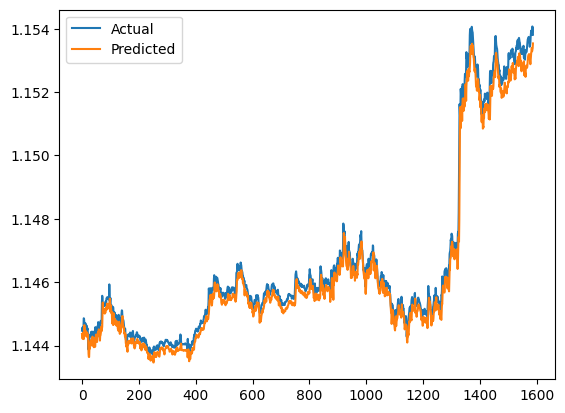

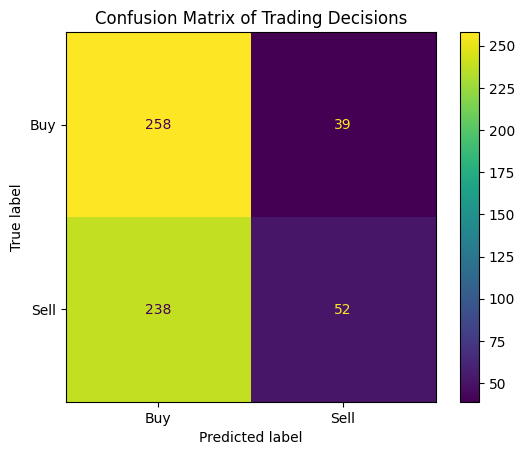

Confusion Matrix:
[[258  39]
 [238  52]]
Relative Confusion Matrix:
[[0.86868687 0.13131313]
 [0.82068966 0.17931034]]


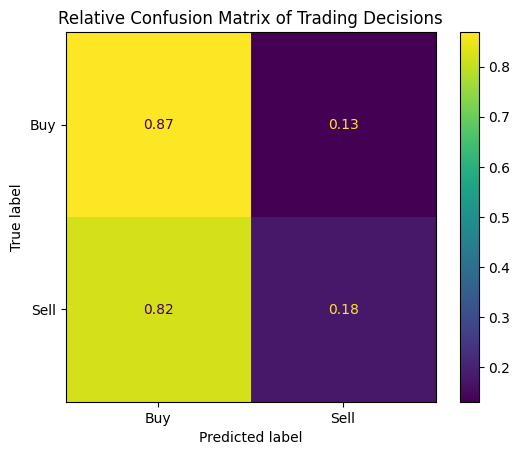

2024-11-02 09:12:39,309 - DEBUG - Data index start: 2019-01-02 00:30:00, end: 2019-01-09 13:54:00
2024-11-02 09:12:39,310 - DEBUG - Length of self.portfolio_series: 1587
2024-11-02 09:12:39,311 - DEBUG - First few entries of self.portfolio_series:
2019-01-08 11:24:00    100000.0000
2019-01-08 11:25:00    100000.0000
2019-01-08 11:26:00    100000.0000
2019-01-08 11:27:00    100000.0000
2019-01-08 11:28:00    100002.1845
Freq: min, dtype: float64
2024-11-02 09:12:39,312 - INFO - Total Number of Trading Days: 2
2024-11-02 09:12:39,312 - INFO - Average Trading Minutes Per Day: 793.50
2024-11-02 09:12:39,313 - DEBUG - Date: 2019-01-08, Minutes: 756
2024-11-02 09:12:39,313 - DEBUG - Date: 2019-01-09, Minutes: 831
2024-11-02 09:12:39,314 - DEBUG - Hit Ratio: 15.333333333333332
2024-11-02 09:12:39,314 - DEBUG - Strategy Gain: 1.2752066400000477
2024-11-02 09:12:39,315 - DEBUG - Maximum Drawdown: -0.0005711617281729531
2024-11-02 09:12:39,315 - DEBUG - Expected Portfolio Return (Rx): 7.99124810

2019-01-08 11:24:00    100000.00000
2019-01-08 11:25:00    100000.00000
2019-01-08 11:26:00    100000.00000
2019-01-08 11:27:00    100000.00000
2019-01-08 11:28:00    100002.18450
                           ...     
2019-01-09 13:46:00    101275.20664
2019-01-09 13:47:00    101275.20664
2019-01-09 13:48:00    101275.20664
2019-01-09 13:49:00    101275.20664
2019-01-09 13:50:00    101275.20664
Freq: min, Length: 1587, dtype: float64
Final portfolio value: $101275.21
Hit Ratio: 15.33%
Strategy Gain: 1.28%
Maximum Drawdown: -0.0571%
Sharpe Ratio: -173.58
Sortino Ratio: -0.89


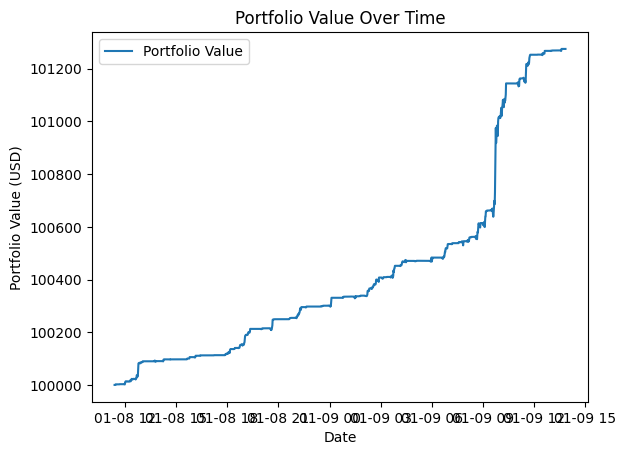

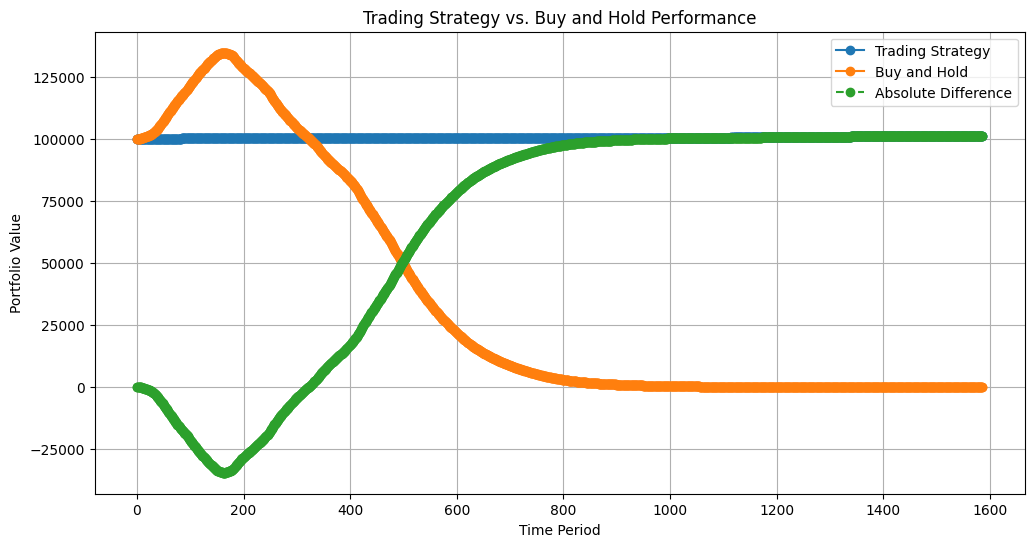

Final Trading Strategy Value: 101275.20664000005
Final Buy and Hold Value: 1.5089538445237927
Absolute Difference: 101273.69768615553


In [39]:
class Model:
    def __init__(self, input_size, hidden_size, output_size, num_layers, device):
        self.device = device
        self.model = self.LSTMModel(input_size, hidden_size, output_size, num_layers, device).to(device)
        self.feature_scaler = MinMaxScaler(feature_range=(0, 1))
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))

    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, num_layers, device):
            super(Model.LSTMModel, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.device = device
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
            out, _ = self.lstm(x, (h0, c0))
            out = self.fc(out[:, -1, :])
            return out

    def load_data(self, file_path):
        self.data = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp').head(8000)
        self.data['log_return'] = np.log(self.data['close'] / self.data['close'].shift(1))
        self.data['Next_High'] = self.data['high'].shift(-1)
        self.data['Return'] = self.data['close'].pct_change()
        self.data['Volatility'] = self.data['Return'].rolling(window=5).std()
        self.data['High_Low_Range'] = (self.data['high'] - self.data['low']) / self.data['low']
        self.data['Prev_Close_Rel_High'] = (self.data['close'].shift(1) - self.data['high']) / self.data['high']
        self.data.dropna(inplace=True)
        return self.data

    def prepare_data(self, time_step=60):
        self.time_step = time_step
        self.features = self.data[['open', 'high', 'low', 'close', 'volume', 'Return', 'Volatility', 'High_Low_Range', 'Prev_Close_Rel_High']].values
        self.targets = self.data['Next_High'].values
        self.features = self.feature_scaler.fit_transform(self.features)
        self.targets = self.target_scaler.fit_transform(self.targets.reshape(-1, 1))

    def create_datasets(self):
        X, y = [], []
        for i in range(len(self.features) - self.time_step):
            X.append(self.features[i:i + self.time_step])
            y.append(self.targets[i + self.time_step])
        X, y = np.array(X), np.array(y)
        split = int(0.8 * len(X))
        self.X_train = torch.tensor(X[:split], dtype=torch.float32)
        self.X_test = torch.tensor(X[split:], dtype=torch.float32)
        self.y_train = torch.tensor(y[:split], dtype=torch.float32)
        self.y_test = torch.tensor(y[split:], dtype=torch.float32)

        # Extract timestamps for the test set
        self.timestamps = self.data.index[split + self.time_step:]
        X_test_numpy = self.X_test.numpy()
        X_test_flat = X_test_numpy.reshape(-1, X_test_numpy.shape[-1])

        # Inverse transform the flattened X_test values
        X_test_flat_original = self.feature_scaler.inverse_transform(X_test_flat)

        # Repeat the timestamps to match the flattened shape
        timestamps_repeated = np.repeat(self.timestamps, self.X_test.shape[1])
        timestamps_repeated = timestamps_repeated[:X_test_flat_original.shape[0]]  # Ensure the lengths match

        # Create DataFrame with the inverse transformed X_test values and repeated timestamps
        self.X_test_df = pd.DataFrame(X_test_flat_original, columns=['open', 'high', 'low', 'close', 'volume', 'Return', 'Volatility', 'High_Low_Range', 'Prev_Close_Rel_High'], index=timestamps_repeated)

    def train(self, X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate, patience):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        train_loader = torch.utils.data.DataLoader(dataset=list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
        best_val_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0
            for features, labels in train_loader:
                features, labels = features.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / len(train_loader)
            self.model.eval()
            with torch.no_grad():
                X_val = X_test.to(self.device)
                y_val = y_test.to(self.device)
                val_loss = criterion(self.model(X_val), y_val).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                torch.save(self.model.state_dict(), 'lstm_model.pth')
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    break

    def evaluate(self, X_test, y_test, target_scaler):
        self.model.eval()
        with torch.no_grad():
            X_test = X_test.to(self.device)
            predictions = self.model(X_test).cpu().numpy()
            y_test = y_test.numpy()
        predictions = target_scaler.inverse_transform(predictions)
        y_test = target_scaler.inverse_transform(y_test)

        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.legend()
        #plt.show()
        return predictions, y_test




# Usage
if __name__ == '__main__':
    bt = BackTesting('pytorch')
    bt.run_backtest('../../EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv')